<a href="https://colab.research.google.com/github/naimish75/AI-Powered-Adverse-Event-Forecasting-Using-Temporal-Data/blob/main/Drug_Train_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install imblearn
!pip install mlxtend
!pip install scikit-learn
!pip install prophet matplotlib
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 110.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 824.7/824.7 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 116.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 15.7 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import joblib
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from collections import Counter
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from tqdm import tqdm
import os

In [ ]:
df_Train = pd.read_csv('/content/drive/MyDrive/DRUG Analysis training/FAERS.csv')

# Convert report_date to datetime format
df_Train["report_date"] = pd.to_datetime(df_Train["report_date"], format="%Y-%m-%d")

# Handle duplicates (keeping the first occurrence)
df_Train = df_Train.drop_duplicates()

# Handle missing values (if any)
df_Train = df_Train.dropna()

# Standardize Drug and Reaction Names (Uppercase & Strip Spaces)
df_Train["drug"] = df_Train["drug"].str.upper().str.strip()
df_Train["reaction"] = df_Train["reaction"].str.upper().str.strip()

# Encode categorical variables
label_enc = LabelEncoder()
df_Train["country_encoded"] = label_enc.fit_transform(df_Train["country"])
df_Train["drug_encoded"] = label_enc.fit_transform(df_Train["drug"])
df_Train["reaction_encoded"] = label_enc.fit_transform(df_Train["reaction"])

# Feature Engineering - Aggregate Data by Report ID
aggregated_data = df_Train.groupby("safetyreport_id").agg({
    "country_encoded": "first",
    "report_date": "first",
    "drug": lambda x: list(x),
    "indication": lambda x: list(x),
    "reaction": lambda x: list(x),
    "drug_encoded": lambda x: list(x),
    "reaction_encoded": lambda x: list(x),
}).reset_index()

# Add temporal features
aggregated_data["year"] = aggregated_data["report_date"].dt.year
aggregated_data["month"] = aggregated_data["report_date"].dt.month

aggregated_data.to_csv('/content/drive/MyDrive/aggregated_data.csv')

In [4]:
df = pd.read_csv('/content/drive/MyDrive/aggregated_data.csv')
df.head()



,Unnamed: 0,safetyreport_id,country_encoded,report_date,drug,indication,reaction,drug_encoded,reaction_encoded,year,month
0,0,3714575,193,2023-02-15,"['GLEEVEC', 'GLEEVEC', 'GLEEVEC']","['Chronic myelomonocytic leukaemia', 'Chronic ...","['SPLENIC RUPTURE', 'GASTROINTESTINAL DISORDER...","[26407, 26407, 26407]","[15771, 6836, 9757]",2023,2
1,1,3730658,193,2023-02-10,"['GLEEVEC', 'GLEEVEC', 'GLEEVEC', 'GLEEVEC', '...","['Myelofibrosis', 'Myelofibrosis', 'Myelofibro...","['PULMONARY EMBOLISM', 'CARDIO-RESPIRATORY ARR...","[26407, 26407, 26407, 26407, 26407, 26407, 264...","[14097, 3052, 5061, 15804, 13146, 12265, 16490...",2023,2
2,2,3731857,193,2023-05-18,"['CYCLOSPORINE', 'CYCLOSPORINE', 'CYCLOSPORINE...","['Renal transplant', 'Renal transplant', 'Rena...","['GLIOBLASTOMA MULTIFORME', 'DEPRESSION', 'MEM...","[16559, 16559, 16559, 16559, 16559, 16559, 165...","[7067, 4781, 10416, 3970, 1302, 7067, 4781, 10...",2023,5
3,3,3737054,193,2023-02-12,"['IMATINIB MESYLATE', 'PREMARIN', 'IBUPROFEN',...","['Chronic myelomonocytic leukaemia', 'Product ...","['SPLENIC RUPTURE', 'SPLENIC RUPTURE', 'SPLENI...","[29442, 47090, 29188, 57606]","[15771, 15771, 15771, 15771]",2023,2
4,4,3773576,11,2023-02-11,"['IMATINIB MESYLATE', 'IMATINIB MESYLATE']","['Chronic myeloid leukaemia', 'Chronic myeloid...","['BONE MARROW NECROSIS', 'OSTEONECROSIS']","[29442, 29442]","[2495, 12129]",2023,2


<ipython-input-5-9bc99a0fb895>:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  trend_data = df.set_index("report_date").resample("M").count().reset_index()
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe4d2w0z0/3b5zs3vv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe4d2w0z0/qkalm2k_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97539', 'data', 'file=/tmp/tmpe4d2w0z0/3b5zs3vv.json', 'init=/tmp/tmpe4d2w0z0/qkalm2k_.json', 'output', 'file=/tmp/tmpe4d2w0z0/prophet_model_vr_j_ti/prophet_model-20250311141945.csv', '

<Figure size 1000x500 with 0 Axes>

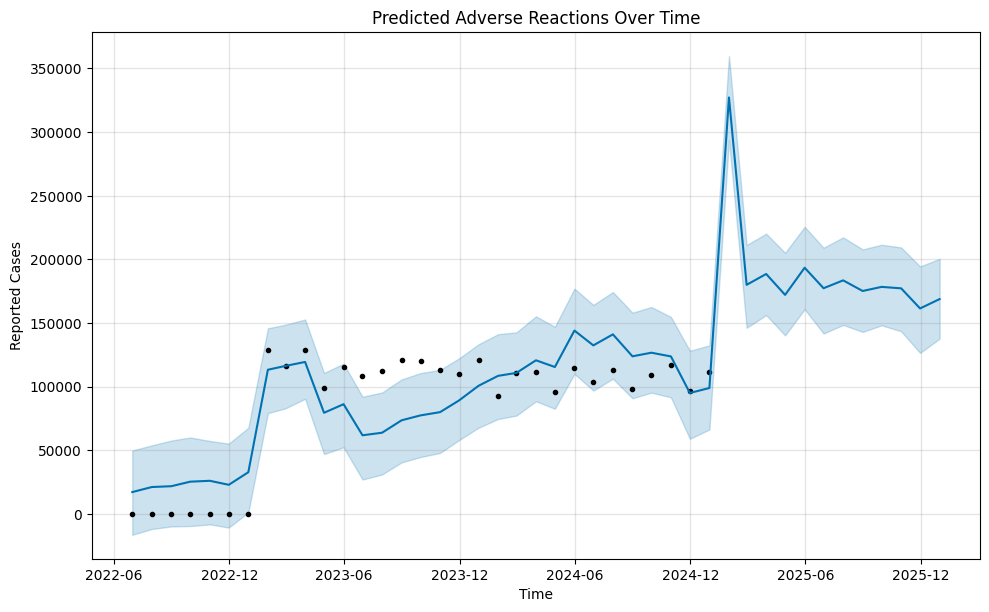

In [5]:
file_path = "/content/drive/MyDrive/aggregated_data.csv"
df = pd.read_csv(file_path, usecols=["report_date", "reaction"])

# Convert report_date to datetime
df["report_date"] = pd.to_datetime(df["report_date"])

# Count reaction occurrences per month
trend_data = df.set_index("report_date").resample("M").count().reset_index()

# Rename columns for Prophet
trend_data.columns = ["ds", "y"]  # Prophet requires 'ds' (date) & 'y' (target)

# Train Prophet model
model = Prophet()
model.fit(trend_data)

# Forecast for the next 12 months
future = model.make_future_dataframe(periods=12, freq="M")
forecast = model.predict(future)

# Plot the forecast
plt.figure(figsize=(10, 5))
model.plot(forecast)
plt.title("Predicted Adverse Reactions Over Time")
plt.xlabel("Time")
plt.ylabel("Reported Cases")
plt.show()


<ipython-input-6-0f0b9c595f46>:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  trend_data = drug_df.set_index("report_date").resample("M").count().reset_index()
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (8) is shorter than m (12). U

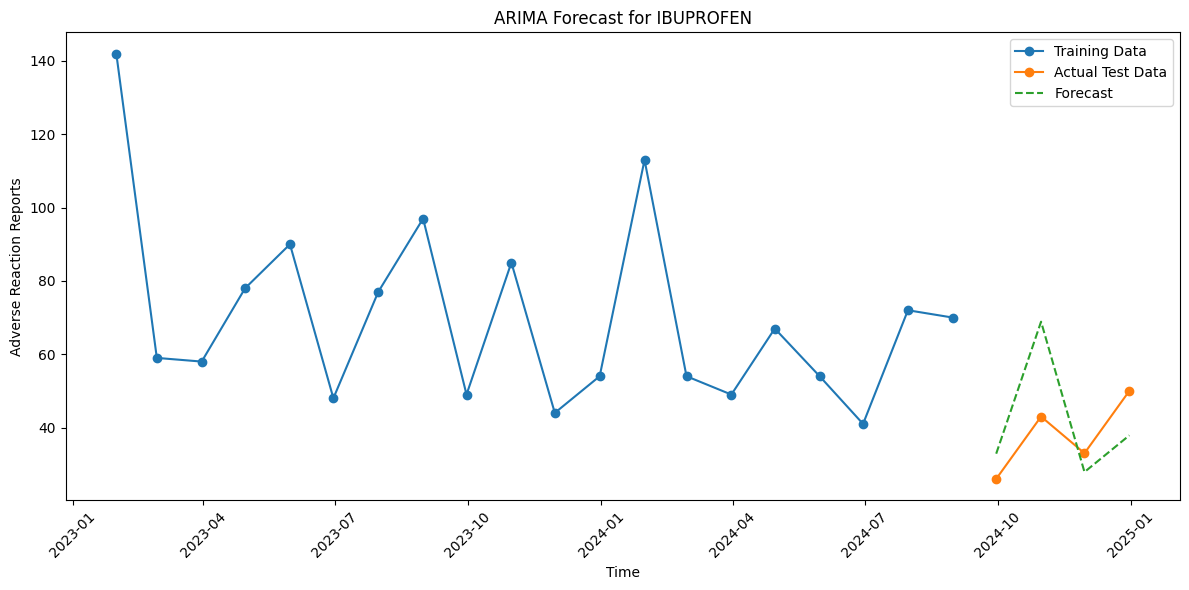

Mean Absolute Error: 12.50
Root Mean Squared Error: 14.92

Actual vs Predicted Values:
         Date  Actual  Predicted
20 2024-09-30      26     32.875
21 2024-10-31      43     68.875
22 2024-11-30      33     27.875
23 2024-12-31      50     37.875


In [6]:
file_path = "/content/drive/MyDrive/aggregated_data.csv"
df = pd.read_csv(file_path, usecols=["report_date", "drug", "reaction"])

# Convert report_date to datetime
df["report_date"] = pd.to_datetime(df["report_date"])

# Fix and clean drug names
df["drug"] = df["drug"].astype(str).str.upper().str.strip().str.replace(r"[^A-Z0-9\s]", "", regex=True)

# Select a specific drug for forecasting
selected_drug = "IBUPROFEN"  # Change as needed
drug_df = df[df["drug"] == selected_drug]

if drug_df.empty:
    print(f"⚠️ No data found for {selected_drug}.")
else:
    # Count adverse reactions per month
    trend_data = drug_df.set_index("report_date").resample("M").count().reset_index()
    trend_data = trend_data[["report_date", "reaction"]]
    trend_data.columns = ["ds", "y"]  # Rename for consistency

    # Split the data into training and testing sets
    train_data = trend_data[trend_data['ds'] < '2024-09-01']
    test_data = trend_data[(trend_data['ds'] >= '2024-09-01') & (trend_data['ds'] <= '2025-01-31')]

    # Train ARIMA model
    model = auto_arima(train_data["y"], seasonal=True, m=12, suppress_warnings=True)

    # Make predictions for the test period
    forecast = model.predict(n_periods=len(test_data))

    # Calculate error metrics
    mae = mean_absolute_error(test_data['y'], forecast)
    rmse = np.sqrt(mean_squared_error(test_data['y'], forecast))

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(train_data["ds"], train_data["y"], label="Training Data", marker="o")
    plt.plot(test_data["ds"], test_data["y"], label="Actual Test Data", marker="o")
    plt.plot(test_data["ds"], forecast, label="Forecast", linestyle="--")
    plt.xlabel("Time")
    plt.ylabel("Adverse Reaction Reports")
    plt.title(f"ARIMA Forecast for {selected_drug}")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")

    # Print actual vs predicted values
    print("\nActual vs Predicted Values:")
    comparison = pd.DataFrame({
        'Date': test_data['ds'],
        'Actual': test_data['y'],
        'Predicted': forecast
    })
    print(comparison)


<ipython-input-7-29486ff0b8a9>:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  trend_data = drug_df.set_index("report_date").resample("M").count().reset_index()
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (8) is shorter than m (12). U

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=2.80 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=65.996, Time=0.01 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=68.976, Time=0.71 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=72.552, Time=0.09 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=67.996, Time=0.10 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=67.994, Time=0.40 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=69.994, Time=0.89 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=66.998, Time=0.11 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=inf, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 6.025 seconds
Best SARIMA parameters: (0, 0, 0), (0, 1, 0, 12)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


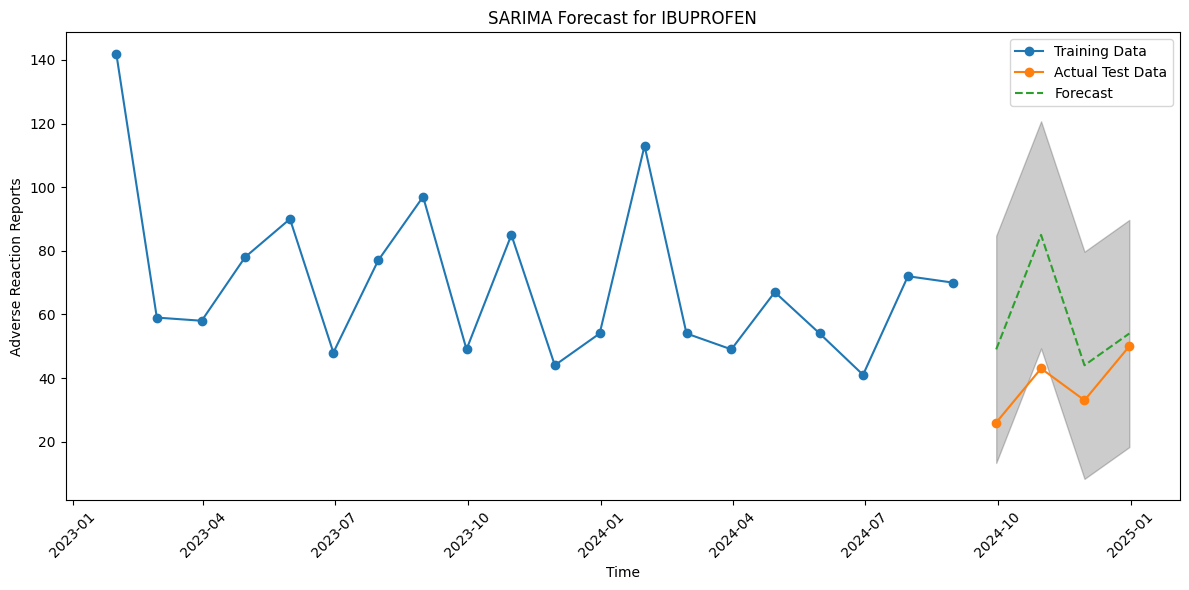

Mean Absolute Error: 20.00
Root Mean Squared Error: 24.65

Actual vs Predicted Values:
         Date  Actual  Predicted
20 2024-09-30      26       49.0
21 2024-10-31      43       85.0
22 2024-11-30      33       44.0
23 2024-12-31      50       54.0


In [7]:
file_path = "/content/drive/MyDrive/aggregated_data.csv"
df = pd.read_csv(file_path, usecols=["report_date", "drug", "reaction"])

# Convert report_date to datetime
df["report_date"] = pd.to_datetime(df["report_date"])

# Fix and clean drug names
df["drug"] = df["drug"].astype(str).str.upper().str.strip().str.replace(r"[^A-Z0-9\s]", "", regex=True)

# Select a specific drug for forecasting
selected_drug = "IBUPROFEN"
drug_df = df[df["drug"] == selected_drug]

if drug_df.empty:
    print(f"⚠️ No data found for {selected_drug}.")
else:
    # Count adverse reactions per month
    trend_data = drug_df.set_index("report_date").resample("M").count().reset_index()
    trend_data = trend_data[["report_date", "reaction"]]
    trend_data.columns = ["ds", "y"]

    # Add seasonal features
    trend_data['month'] = trend_data['ds'].dt.month
    trend_data['year'] = trend_data['ds'].dt.year

    # Split the data
    train_data = trend_data[trend_data['ds'] < '2024-09-01']
    test_data = trend_data[(trend_data['ds'] >= '2024-09-01') & (trend_data['ds'] <= '2025-01-31')]

    # Find best SARIMA parameters
    best_model = auto_arima(train_data['y'], seasonal=True, m=12, suppress_warnings=True, trace=True)
    print(f"Best SARIMA parameters: {best_model.order}, {best_model.seasonal_order}")

    # Train SARIMA model with best parameters
    model = SARIMAX(train_data['y'],
                    order=best_model.order,
                    seasonal_order=best_model.seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    results = model.fit()

    # Make predictions
    forecast = results.get_forecast(steps=len(test_data))
    forecast_mean = forecast.predicted_mean

    # Calculate error metrics
    mae = mean_absolute_error(test_data['y'], forecast_mean)
    rmse = np.sqrt(mean_squared_error(test_data['y'], forecast_mean))

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(train_data["ds"], train_data["y"], label="Training Data", marker="o")
    plt.plot(test_data["ds"], test_data["y"], label="Actual Test Data", marker="o")
    plt.plot(test_data["ds"], forecast_mean, label="Forecast", linestyle="--")
    plt.fill_between(test_data["ds"],
                     forecast.conf_int()['lower y'],
                     forecast.conf_int()['upper y'],
                     color='k', alpha=.2)
    plt.xlabel("Time")
    plt.ylabel("Adverse Reaction Reports")
    plt.title(f"SARIMA Forecast for {selected_drug}")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")

    # Print actual vs predicted values
    print("\nActual vs Predicted Values:")
    comparison = pd.DataFrame({
        'Date': test_data['ds'],
        'Actual': test_data['y'],
        'Predicted': forecast_mean
    })
    print(comparison)


<ipython-input-9-1eba71154aef>:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  trend_data = drug_df.set_index("report_date").resample("M").count().reset_index()
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/u

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.85 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=231.563, Time=0.09 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=218.897, Time=0.22 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=229.878, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=229.262, Time=0.10 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=3.49 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=220.783, Time=1.00 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.41 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=4.19 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=220.753, Time=0.22 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=213.083, Time=0.48 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=220.477, Time=0.20 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=4.29 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.02 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.60 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=4.98 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(1,0,0)[12] intercept   : AIC=212.511, Time=0.72 sec
 ARIMA(3,1,0)(0,0,0)[12] intercept   : AIC=220.121, Time=0.20 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=4.38 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.49 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.81 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=5.90 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=1.01 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(1,0,0)[12] intercept   : AIC=inf, Time=1.40 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=inf, Time=1.19 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(1,0,0)[12] intercept   : AIC=207.138, Time=1.62 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.31 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(2,0,0)[12] intercept   : AIC=210.045, Time=6.47 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(1,0,1)[12] intercept   : AIC=209.064, Time=2.01 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=1.20 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(2,0,1)[12] intercept   : AIC=inf, Time=7.30 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(1,0,0)[12] intercept   : AIC=207.009, Time=2.31 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.41 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(2,0,0)[12] intercept   : AIC=208.830, Time=7.48 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(1,0,1)[12] intercept   : AIC=210.835, Time=2.41 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=1.41 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(2,0,1)[12] intercept   : AIC=inf, Time=8.88 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(1,0,0)[12] intercept   : AIC=207.950, Time=1.32 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,2)(1,0,0)[12] intercept   : AIC=215.546, Time=2.28 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(1,0,0)[12] intercept   : AIC=inf, Time=1.81 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(1,0,0)[12]             : AIC=206.614, Time=1.50 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(0,0,0)[12]             : AIC=224.500, Time=0.24 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(2,0,0)[12]             : AIC=207.906, Time=6.95 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(1,0,1)[12]             : AIC=208.884, Time=2.39 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(0,0,1)[12]             : AIC=inf, Time=1.01 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(2,0,1)[12]             : AIC=inf, Time=7.49 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(1,0,0)[12]             : AIC=207.955, Time=1.01 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(1,0,0)[12]             : AIC=inf, Time=0.98 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,2)(1,0,0)[12]             : AIC=208.843, Time=2.01 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(1,0,0)[12]             : AIC=inf, Time=0.70 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(1,0,0)[12]             : AIC=206.415, Time=1.40 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,0)[12]             : AIC=inf, Time=0.30 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(2,0,0)[12]             : AIC=209.771, Time=6.49 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(1,0,1)[12]             : AIC=207.917, Time=2.11 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,1)[12]             : AIC=inf, Time=1.29 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(2,0,1)[12]             : AIC=209.843, Time=7.49 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(1,0,0)[12]             : AIC=inf, Time=0.62 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(1,0,0)[12]             : AIC=inf, Time=1.79 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(1,0,0)[12]             : AIC=209.838, Time=0.41 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(1,0,0)[12]             : AIC=inf, Time=1.30 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,3)(1,0,0)[12]             : AIC=inf, Time=2.09 sec

Best model:  ARIMA(4,1,2)(1,0,0)[12]          
Total fit time: 137.741 seconds


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-9-1eba71154aef>:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(start=trend_data["ds"].max(), periods=12, freq="M"), forecast, label="Forecast", linestyle="--")


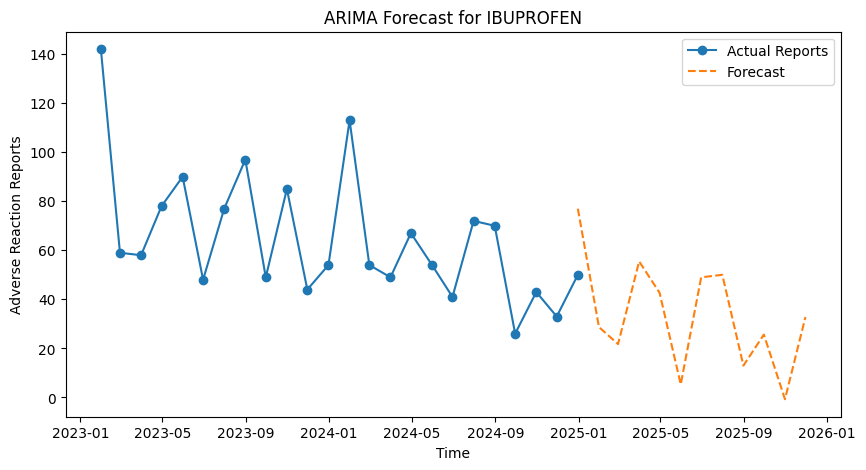

In [9]:
file_path = "/content/drive/MyDrive/aggregated_data.csv"
df = pd.read_csv(file_path, usecols=["report_date", "drug", "reaction"])

# Convert report_date to datetime
df["report_date"] = pd.to_datetime(df["report_date"])

# Fix and clean drug names
df["drug"] = df["drug"].astype(str).str.upper().str.strip().str.replace(r"[^A-Z0-9\s]", "", regex=True)

# Select a specific drug for forecasting
selected_drug = "IBUPROFEN"  # Change as needed
drug_df = df[df["drug"] == selected_drug]

if drug_df.empty:
    print(f"⚠️ No data found for {selected_drug}.")
else:
    # Count adverse reactions per month
    trend_data = drug_df.set_index("report_date").resample("M").count().reset_index()
    trend_data = trend_data[["report_date", "reaction"]]
    trend_data.columns = ["ds", "y"]  # Rename for consistency

    # Train ARIMA model
    model = auto_arima(trend_data["y"], seasonal=True, m=12, trace=True)

    # Make future predictions (12 months)
    forecast = model.predict(n_periods=12)

    # Plot the results
    plt.figure(figsize=(10, 5))
    plt.plot(trend_data["ds"], trend_data["y"], label="Actual Reports", marker="o")
    plt.plot(pd.date_range(start=trend_data["ds"].max(), periods=12, freq="M"), forecast, label="Forecast", linestyle="--")
    plt.xlabel("Time")
    plt.ylabel("Adverse Reaction Reports")
    plt.title(f"ARIMA Forecast for {selected_drug}")
    plt.legend()
    plt.show()


In [10]:
# file_path = "/content/drive/MyDrive/aggregated_data.csv"
# df = pd.read_csv(file_path, usecols=["report_date", "drug", "reaction"])

# # Convert report_date to datetime
# df["report_date"] = pd.to_datetime(df["report_date"])

# # Fix and clean drug names
# df["drug"] = df["drug"].astype(str).str.upper().str.strip().str.replace(r"[^A-Z0-9\s]", "", regex=True)

# # Create a directory to store models
# os.makedirs("arima_models", exist_ok=True)

# # Get the top N most common drugs
# N = 50  # You can adjust this number
# top_drugs = df["drug"].value_counts().nlargest(N).index.tolist()

# # Train ARIMA models for each drug
# for drug in tqdm(top_drugs, desc="Training ARIMA models"):
#     drug_df = df[df["drug"] == drug]

#     if len(drug_df) < 24:  # Skip drugs with less than 2 years of data
#         continue

#     # Count adverse reactions per month
#     trend_data = drug_df.set_index("report_date").resample("M").count().reset_index()
#     trend_data = trend_data[["report_date", "reaction"]]
#     trend_data.columns = ["ds", "y"]

#     try:
#         # Train ARIMA model
#         model = auto_arima(trend_data["y"], seasonal=True, m=12, suppress_warnings=True, error_action="ignore")

#         # Save the model
#         joblib.dump(model, f"arima_models/{drug}_arima_model.joblib")

#     except Exception as e:
#         print(f"Error training model for {drug}: {str(e)}")